In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf
from skimage.transform import rotate
from scipy.ndimage import binary_fill_holes
from tensorflow.keras.models import load_model

In [2]:
# Clear GPU memory before starting
def clear_gpu_memory():
    try:
        from numba import cuda
        device = cuda.get_current_device()
        device.reset()
    except:
        pass
    # Clear TensorFlow session
    tf.keras.backend.clear_session()
    # Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        for device in physical_devices:
            try:
                tf.config.experimental.set_memory_growth(device, True)
                print(f"Memory growth enabled for GPU device: {device}")
            except:
                print("Error enabling memory growth")

clear_gpu_memory()

Loading U-Net model...
Starting lung mask generation...
Processing with target size (224, 224) and model input size (256, 256)
1/1 [==============================] - 3s 3s/step
Final mask shape: (224, 224)
Final image shape: (224, 224)
Generated lung mask shape: (224, 224)
Original X-ray shape: (224, 224)
About to calculate CTR...
Debug - lung_pixels shape before processing: (13504, 2)
Debug - points shape after processing: (13504, 2)
Detected midline at x=118 (image width=224)
CTR calculation complete: 0.608


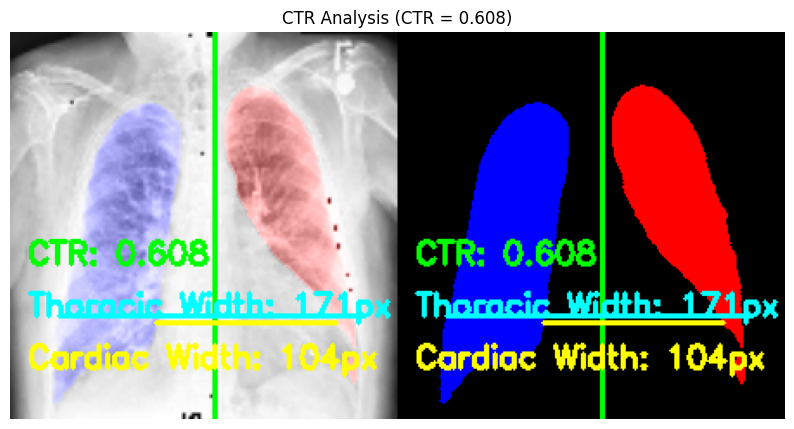

CTR Value: 0.608
Detailed measurements:
  thoracic_width: 171
  thoracic_row: 164
  left_thoracic: 28
  right_thoracic: 199
  cardiac_width: 104
  cardiac_row: 168
  left_cardiac: 84
  right_cardiac: 188
  ctr: 0.6081871345029239
  midline: 118


In [ ]:


def load_and_preprocess_xray(image_path, target_size=(224, 224), model_input_size=(256, 256)):
    """
    Load and preprocess an X-ray image for lung segmentation.
    Handles conversion between target_size and model_input_size.
    """
    # Load image
    if isinstance(image_path, str):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = cv2.imread(image_path, 0)  # Load as grayscale
    else:
        # Assume it's already a numpy array
        image = image_path.copy()
        if len(image.shape) > 2:  # Convert to grayscale if needed
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Check if image loaded correctly
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Store original shape
    original_shape = image.shape
    
    # Resize for target size (for later use)
    resized_for_target = cv2.resize(image, target_size)
    
    # Resize for model input
    resized_for_model = cv2.resize(image, model_input_size)
    
    # Normalize pixel values to [0, 1]
    normalized_img = resized_for_model / 255.0
    
    # Expand dimensions for model input
    input_img = np.expand_dims(np.expand_dims(normalized_img, axis=-1), axis=0)
    
    return input_img, original_shape, resized_for_target

def generate_lung_mask(model, image_path, target_size=(224, 224), model_input_size=(256, 256), threshold=0.5):
    """
    Generate lung segmentation mask using the pre-trained U-Net model.
    Handles conversion between target_size (224x224) and model_input_size (256x256).
    """
    # Preprocess the image
    input_img, original_shape, resized_target = load_and_preprocess_xray(
        image_path, target_size=target_size, model_input_size=model_input_size
    )
    
    # Predict with the model (assumes model expects 256x256)
    predicted_mask = model.predict(input_img)[0]
    
    # Convert to binary mask
    binary_mask = (predicted_mask[:, :, 0] > threshold).astype(np.uint8)
    
    # Post-process the mask
    binary_mask = post_process_mask(binary_mask)
    
    # Resize the mask to match the target size (224x224)
    if binary_mask.shape[:2] != target_size:
        binary_mask = cv2.resize(binary_mask, target_size)
    
    print(f"Final mask shape: {binary_mask.shape}")
    print(f"Final image shape: {resized_target.shape}")
    
    return binary_mask, resized_target

def post_process_mask(mask):
    """
    Post-process the predicted mask to improve segmentation quality.
    """
    # Fill holes in the mask
    filled_mask = binary_fill_holes(mask).astype(np.uint8)
    
    # Apply morphological operations to smooth boundaries
    kernel = np.ones((3, 3), np.uint8)
    opened_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return closed_mask

def correct_rotation(image, mask):
    """
    Correct rotation of the chest X-ray based on lung segmentation.
    """
    # Find the orientation based on lung mask
    lung_pixels = np.argwhere(mask > 0)
    
    # Debug print
    print(f"Debug - lung_pixels shape before processing: {lung_pixels.shape}")
    
    if len(lung_pixels) < 10:  # Not enough points to determine orientation
        return image, mask
    
    # Convert to the format expected by cv2.fitLine
    # OpenCV expects points as rows of (x, y) coordinates
    # But np.argwhere returns (row, col) which is (y, x)
    # So we need to swap columns for proper fitLine input
    points = lung_pixels.astype(np.float32)
    
    # This is critical: ensure points are in the right format
    if points.shape[1] == 2:
        # Swap columns to convert from (y,x) to (x,y) format
        points = np.column_stack((points[:, 1], points[:, 0]))
    
    # Debug print
    print(f"Debug - points shape after processing: {points.shape}")
    
    try:
        vx, vy, x0, y0 = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
        
        # Unpack the outputs correctly
        vx = float(vx[0])
        vy = float(vy[0])
        x0 = float(x0[0])
        y0 = float(y0[0])
        
        # Calculate the angle of the line
        angle = np.degrees(np.arctan2(vy, vx))
        
        # Calculate correction angle
        if angle > 45:
            correction = 90 - angle
        elif angle < -45:
            correction = -90 - angle
        else:
            # If the angle is not close to vertical, we don't rotate
            return image, mask
        
        # Only correct if the rotation is significant (more than 2 degrees)
        if abs(correction) < 2:
            return image, mask
        
        # Rotate both the image and mask
        rotated_image = rotate(image, correction, preserve_range=True).astype(np.uint8)
        rotated_mask = rotate(mask, correction, preserve_range=True).astype(np.uint8)
        
        return rotated_image, rotated_mask
    
    except Exception as e:
        print(f"Error in rotation detection: {str(e)}")
        # Return original images if rotation detection fails
        return image, mask

def detect_midline(mask):
    """
    Detect the vertical midline of the chest X-ray based on lung segmentation.
    Uses radiological principles to place the midline precisely at the spine position.
    """
    h, w = mask.shape
    
    # Create arrays to store the gap centers at each row
    gap_centers = []
    gap_rows = []
    
    # Analyze rows where both lungs are clearly visible
    for row in range(h):
        row_data = mask[row, :]
        
        # Skip rows with minimal lung tissue
        if np.sum(row_data) < w * 0.1:  # At least 10% of row should be lung tissue
            continue
            
        # Convert to run-length encoding to find gaps
        runs = np.where(np.diff(np.hstack([[0], row_data, [0]])))[0]
        
        # If we have an even number of transitions, we have complete lung segments
        if len(runs) >= 4:  # At least two separate regions (4 transitions)
            # Group transitions to identify lungs and gaps
            regions = runs.reshape(-1, 2)
            
            # Check for a clear gap between two distinct lung regions
            # First, find the biggest two lung regions
            lung_sizes = regions[:, 1] - regions[:, 0]
            if len(lung_sizes) < 2:
                continue
                
            # Get indices of the two largest regions (presumed to be lungs)
            largest_indices = np.argsort(lung_sizes)[-2:]
            largest_indices.sort()  # Sort so left lung comes before right lung
            
            if len(largest_indices) >= 2:
                left_region = regions[largest_indices[0]]
                right_region = regions[largest_indices[1]]
                
                # Make sure the regions are separated (not touching)
                if left_region[1] < right_region[0]:
                    # Calculate the center of the gap between these regions
                    gap_center = (left_region[1] + right_region[0]) // 2
                    gap_centers.append(gap_center)
                    gap_rows.append(row)
    
    # If we have enough gap centers, calculate the median position
    if len(gap_centers) > h * 0.1:  # At least 10% of rows have valid gaps
        # Use median for robustness against outliers
        midline = int(np.median(gap_centers))
        
        # Verify the midline is reasonable (not too far from center)
        if abs(midline - w//2) > w//3:
            print("Warning: Calculated midline is far from center, using geometric center.")
            midline = w // 2
    else:
        # Fallback to geometric center
        print("Warning: Could not detect reliable gap between lungs, using geometric center.")
        midline = w // 2
    
    # Debug information
    print(f"Detected midline at x={midline} (image width={w})")
    
    return midline
    
    # Debug information
    print(f"Detected midline at x={midline} (image width={w})")
    
    return midline

def calculate_ctr(original_xray, lung_mask, visualize=True):
    """
    Calculate the Cardiothoracic Ratio (CTR) from a chest X-ray and its lung segmentation mask.
    Enhanced to better find the maximum cardiac width.
    """
    # Ensure inputs are valid
    if original_xray is None or lung_mask is None:
        raise ValueError("Input images cannot be None")
    
    # Make sure lung_mask is binary
    if lung_mask.max() > 1:
        _, lung_mask = cv2.threshold(lung_mask, 127, 1, cv2.THRESH_BINARY)
    
    # Correct rotation if needed
    original_xray, lung_mask = correct_rotation(original_xray, lung_mask)
    
    # Get image dimensions
    h, w = lung_mask.shape[:2]
    
    # Find the true midline
    midline = detect_midline(lung_mask)
    
    # Find rows with lung tissue (avoid empty rows)
    rows_with_lungs = np.where(np.sum(lung_mask, axis=1) > 10)[0]
    
    if len(rows_with_lungs) == 0:
        raise ValueError("No lung tissue detected in the segmentation mask")
    
    # Define anatomical regions based on lung segmentation
    lung_top = np.min(rows_with_lungs)
    lung_bottom = np.max(rows_with_lungs)
    lung_height = lung_bottom - lung_top
    
    # Calculate the typical position for thoracic measurement (lower third)
    thoracic_search_start = int(lung_top + lung_height * 0.6)
    thoracic_search_end = int(lung_top + lung_height * 0.8)
    
    # Find the thoracic diameter at each valid row in the lower third
    max_thoracic_width = 0
    max_thoracic_row = 0
    max_left_thoracic = 0
    max_right_thoracic = 0
    
    for row in range(thoracic_search_start, thoracic_search_end):
        # Get the row data
        if row >= h:
            continue
            
        row_data = lung_mask[row, :]
        
        # Find left and right thoracic boundaries
        left_indices = np.where(row_data > 0)[0]
        if len(left_indices) == 0:
            continue
            
        # Separate left and right lung
        left_lung_indices = left_indices[left_indices < midline]
        right_lung_indices = left_indices[left_indices >= midline]
        
        if len(left_lung_indices) == 0 or len(right_lung_indices) == 0:
            continue
        
        # Get thoracic boundaries
        left_thoracic = np.min(left_lung_indices)
        right_thoracic = np.max(right_lung_indices)
        
        thoracic_width = right_thoracic - left_thoracic
        
        # Keep track of the maximum thoracic width
        if thoracic_width > max_thoracic_width:
            max_thoracic_width = thoracic_width
            max_thoracic_row = row
            max_left_thoracic = left_thoracic
            max_right_thoracic = right_thoracic
    
    # If we couldn't find a valid thoracic measurement in the ideal region,
    # search the entire lung area
    if max_thoracic_width == 0:
        for row in rows_with_lungs:
            row_data = lung_mask[row, :]
            left_indices = np.where(row_data > 0)[0]
            
            if len(left_indices) == 0:
                continue
                
            left_lung_indices = left_indices[left_indices < midline]
            right_lung_indices = left_indices[left_indices >= midline]
            
            if len(left_lung_indices) == 0 or len(right_lung_indices) == 0:
                continue
            
            left_thoracic = np.min(left_lung_indices)
            right_thoracic = np.max(right_lung_indices)
            thoracic_width = right_thoracic - left_thoracic
            
            if thoracic_width > max_thoracic_width:
                max_thoracic_width = thoracic_width
                max_thoracic_row = row
                max_left_thoracic = left_thoracic
                max_right_thoracic = right_thoracic
    
    if max_thoracic_width == 0:
        raise ValueError("Could not determine thoracic width")
    
    # ENHANCED CARDIAC WIDTH CALCULATION: 
    # Search a broader area - from top 20% to bottom 80% of lung height
    # This ensures we capture the maximum cardiac width which may be higher up
    cardiac_search_start = int(lung_top + lung_height * 0.2)
    cardiac_search_end = int(lung_top + lung_height * 0.8)
    
    # Initialize variables for cardiac measurement
    max_cardiac_width = 0
    max_cardiac_row = 0
    max_left_cardiac = 0
    max_right_cardiac = 0
    
    # Create a mask for visualization of cardiac search area
    cardiac_search_mask = np.zeros_like(lung_mask)
    cardiac_search_mask[cardiac_search_start:cardiac_search_end, :] = 1
    
    # For each row in the search area, find the cardiac width by measuring the gap between lungs
    for row in range(cardiac_search_start, cardiac_search_end):
        if row >= h:
            continue
            
        # Get the row data from the lung mask
        row_data = lung_mask[row, :]
        
        # Calculate left and right lung boundaries at this row
        left_indices = np.where(row_data > 0)[0]
        if len(left_indices) == 0:
            continue
            
        left_lung_indices = left_indices[left_indices < midline]
        right_lung_indices = left_indices[left_indices >= midline]
        
        if len(left_lung_indices) == 0 or len(right_lung_indices) == 0:
            continue
        
        # Find rightmost point of left lung and leftmost point of right lung
        left_lung_right_border = np.max(left_lung_indices)
        right_lung_left_border = np.min(right_lung_indices)
        
        # Calculate cardiac width at this row (the gap between lungs)
        cardiac_width = right_lung_left_border - left_lung_right_border
        
        # Skip if there's no gap or negative width
        if cardiac_width <= 0:
            continue
            
        # Keep track of maximum cardiac width
        if cardiac_width > max_cardiac_width:
            max_cardiac_width = cardiac_width
            max_cardiac_row = row
            max_left_cardiac = left_lung_right_border
            max_right_cardiac = right_lung_left_border
    
    # If we couldn't find a valid cardiac measurement, try an alternative method
    if max_cardiac_width == 0:
        # Apply edge detection on the original X-ray
        edges = cv2.Canny(original_xray, 50, 150)
        
        # Look for edges in the central region
        center_width = w // 3
        center_start = midline - center_width // 2
        center_end = midline + center_width // 2
        
        for row in range(cardiac_search_start, cardiac_search_end):
            if row >= h:
                continue
                
            # Find edges in this row within the central region
            edge_indices = np.where(edges[row, center_start:center_end] > 0)[0] + center_start
            
            if len(edge_indices) >= 2:
                left_edge = np.min(edge_indices)
                right_edge = np.max(edge_indices)
                cardiac_width = right_edge - left_edge
                
                if cardiac_width > max_cardiac_width:
                    max_cardiac_width = cardiac_width
                    max_cardiac_row = row
                    max_left_cardiac = left_edge
                    max_right_cardiac = right_edge
    
    if max_cardiac_width == 0:
        raise ValueError("Could not determine cardiac width")
    
    # Calculate CTR
    ctr_value = max_cardiac_width / max_thoracic_width
    
    # Create a dictionary to store all measurements
    measurements = {
        'thoracic_width': max_thoracic_width,
        'thoracic_row': max_thoracic_row,
        'left_thoracic': max_left_thoracic,
        'right_thoracic': max_right_thoracic,
        'cardiac_width': max_cardiac_width,
        'cardiac_row': max_cardiac_row,
        'left_cardiac': max_left_cardiac,
        'right_cardiac': max_right_cardiac,
        'ctr': ctr_value,
        'midline': midline
    }
    
    # Create visualization if requested
    result_image = None
    if visualize:
        # Create a color mask for visualization
        color_mask = np.zeros((h, w, 3), dtype=np.uint8)
        # Blue for left lung, red for right lung
        for col in range(w):
            for row in range(h):
                if lung_mask[row, col] > 0:
                    if col < midline:
                        color_mask[row, col] = [255, 0, 0]  # Blue for left lung
                    else:
                        color_mask[row, col] = [0, 0, 255]  # Red for right lung
        
        # Convert grayscale to RGB for colored visualization
        if len(original_xray.shape) == 2:
            result_image = cv2.cvtColor(original_xray, cv2.COLOR_GRAY2BGR)
        else:
            result_image = original_xray.copy()
        
        # Overlay the color mask with transparency
        alpha = 0.3  # Transparency factor
        mask_overlay = cv2.addWeighted(result_image, 1.0, color_mask, alpha, 0)
        
        # Create a separate visualization for the segmentation mask
        mask_vis = color_mask.copy()
        
        # Draw midline on both visualizations
    # When drawing the midline in the calculate_ctr function:
        cv2.line(mask_overlay, 
         (midline, 0), 
         (midline, h), 
         (0, 255, 0), 2)  # Make the line thicker (2px) and bright green

        cv2.line(mask_vis, 
         (midline, 0), 
         (midline, h), 
         (0, 255, 0), 2)  # Make the line thicker (2px) and bright green
        
        # Draw thoracic measurement line
        cv2.line(mask_overlay, 
                 (max_left_thoracic, max_thoracic_row), 
                 (max_right_thoracic, max_thoracic_row), 
                 (255, 255, 0), 2)  # Yellow line for thoracic width
        
        cv2.line(mask_vis, 
                 (max_left_thoracic, max_thoracic_row), 
                 (max_right_thoracic, max_thoracic_row), 
                 (255, 255, 0), 2)  # Yellow line for thoracic width
        
        # Draw cardiac measurement line
        cv2.line(mask_overlay, 
                 (max_left_cardiac, max_cardiac_row), 
                 (max_right_cardiac, max_cardiac_row), 
                 (0, 255, 255), 2)  # Cyan line for cardiac width
        
        cv2.line(mask_vis, 
                 (max_left_cardiac, max_cardiac_row), 
                 (max_right_cardiac, max_cardiac_row), 
                 (0, 255, 255), 2)  # Cyan line for cardiac width
        
        # Add text showing measurements to both images
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 2
        
        # Add CTR text in green
        cv2.putText(mask_overlay, 
                    f"CTR: {ctr_value:.3f}", 
                    (10, h - 90), 
                    font, font_scale, (0, 255, 0), font_thickness)
        
        cv2.putText(mask_vis, 
                    f"CTR: {ctr_value:.3f}", 
                    (10, h - 90), 
                    font, font_scale, (0, 255, 0), font_thickness)
        
        # Add thoracic width text in yellow
        cv2.putText(mask_overlay, 
                    f"Thoracic Width: {max_thoracic_width}px", 
                    (10, h - 60), 
                    font, font_scale, (255, 255, 0), font_thickness)
        
        cv2.putText(mask_vis, 
                    f"Thoracic Width: {max_thoracic_width}px", 
                    (10, h - 60), 
                    font, font_scale, (255, 255, 0), font_thickness)
        
        # Add cardiac width text in cyan
        cv2.putText(mask_overlay, 
                    f"Cardiac Width: {max_cardiac_width}px", 
                    (10, h - 30), 
                    font, font_scale, (0, 255, 255), font_thickness)
        
        cv2.putText(mask_vis, 
                    f"Cardiac Width: {max_cardiac_width}px", 
                    (10, h - 30), 
                    font, font_scale, (0, 255, 255), font_thickness)
        
        # Combine the two visualizations side by side
        combined_vis = np.hstack((mask_overlay, mask_vis))
        result_image = combined_vis
    
    return ctr_value, result_image, measurements

def process_xray_for_ctr(xray_path, model_path, visualize=True, save_results=True, 
                         output_dir='results', target_size=(224, 224), model_input_size=(256, 256)):
    """
    Complete pipeline for CTR calculation from a chest X-ray.
    Enhanced to save mask visualization and better cardiac width detection.
    """
    try:
        # Create output directory if needed
        if save_results and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Load the pre-trained model
        print("Loading U-Net model...")
        model = tf.keras.models.load_model(model_path)
        
        # Generate lung mask
        print("Starting lung mask generation...")
        print(f"Processing with target size {target_size} and model input size {model_input_size}")
        lung_mask, original_xray = generate_lung_mask(
            model, 
            xray_path, 
            target_size=target_size, 
            model_input_size=model_input_size
        )
        print(f"Generated lung mask shape: {lung_mask.shape}")
        print(f"Original X-ray shape: {original_xray.shape}")
        
        # Calculate CTR with the enhanced approach
        print("About to calculate CTR...")
        ctr_value, visualization, measurements = calculate_ctr(original_xray, lung_mask, visualize)
        
        # Save results if requested
        if save_results:
            # Get base filename without extension
            base_name = os.path.splitext(os.path.basename(xray_path))[0]
            
            # Save binary lung mask
            mask_path = os.path.join(output_dir, f"{base_name}_lung_mask.png")
            cv2.imwrite(mask_path, lung_mask * 255)
            
            # Save visualization if created
            if visualization is not None:
                vis_path = os.path.join(output_dir, f"{base_name}_ctr_analysis.png")
                cv2.imwrite(vis_path, visualization)
            
            # Save measurements as text
            meas_path = os.path.join(output_dir, f"{base_name}_ctr_measurements.txt")
            with open(meas_path, 'w') as f:
                f.write(f"CTR: {ctr_value:.3f}\n")
                for key, value in measurements.items():
                    f.write(f"{key}: {value}\n")
        
        print(f"CTR calculation complete: {ctr_value:.3f}")
        return ctr_value, visualization, measurements
        
    except Exception as e:
        import traceback
        print(f"Error in CTR calculation pipeline: {str(e)}")
        traceback.print_exc()
        raise
        
# Example usage
def main():
    try:
        # Paths to input files
    # Default paths - replace with your actual paths
        model_path = r"D:\varun\Major project\Major Project\lung_segmentation_unet.h5"
        
        # Process the X-ray and calculate CTR
        ctr, visualization, measurements = process_xray_for_ctr(
        xray_path=image_path,
        model_path=model_path,
        visualize=True,
        save_results=True,
        output_dir='ctr_results',
        target_size=(224, 224),  # Your desired output size
        model_input_size=(256, 256)  # Size your model expects
        )
        
        # Display results
        if visualization is not None:
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
            plt.title(f"CTR Analysis (CTR = {ctr:.3f})")
            plt.axis('off')
            plt.show()
            
        print(f"CTR Value: {ctr:.3f}")
        print("Detailed measurements:")
        for key, value in measurements.items():
            print(f"  {key}: {value}")
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")

if __name__ == "__main__":
    main()